| Action ID | Action Name  | One-Hot Encoded Label    |
|-----------|--------------|--------------------------|
| 1         | up           | `[1, 0, 0, 0, 0]`        |
| 2         | down         | `[0, 1, 0, 0, 0]`        |
| 3         | left         | `[0, 0, 1, 0, 0]`        |
| 4         | right        | `[0, 0, 0, 1, 0]`        |
| 5         | eyeclosed    | `[0, 0, 0, 0, 1]`        |


In [1]:
import os
import random
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, Dropout, Flatten, LSTM, MaxPooling1D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint

from scipy.io import loadmat
from scipy.signal import stft
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.stats import skew, kurtosis

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.layers import TimeDistributed, Bidirectional


2024-06-28 22:58:53.194933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2024-06-28 22:58:53.194965: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%load_ext tensorboard

In [3]:
%tensorboard --logdir logs/motion_final --port 6001

# 3D reshaping

In [4]:
def reshape_row(row):
    electrode_matrix = np.array([
        [0, 0, 0, 'AF3', 0, 0, 'AF4', 0, 0, 0],
        [0, 'F7', 0, 0, 'F3', 'F4', 0, 0, 'F8', 0],
        [0, 0, 'FC5', 0, 0, 0, 0, 'FC6', 0, 0],
        ['T7', 0, 0, 0, 0, 0, 0, 0, 0, 'T8'],
        [0, 0, 'P7', 0, 0, 0, 0, 'P8', 0, 0],
        [0, 0, 0, 0, 'O1', 'O2', 0, 0, 0, 0]
    ])
    # Map each value in the row to the corresponding position in electrode_matrix
    for i, col in enumerate(electrode_matrix.flatten()):
        if col in row.index:
            electrode_matrix[np.where(electrode_matrix == col)] = row[col]

    return electrode_matrix

# Normalization on each subject 

In [5]:
def submin_max_scale_subjects(df, columns_to_normalize, subject_column='subject'):
    scaler = MinMaxScaler()
    normalized_data = pd.DataFrame()
    
    for subject, group in df.groupby(subject_column):
        group[columns_to_normalize] = scaler.fit_transform(group[columns_to_normalize])
        normalized_data = pd.concat([normalized_data, group])
    
    return normalized_data

# Keras

In [6]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, Lambda
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns


def preprocess_3d_data(df, labels):
    transformed_data = np.array([reshape_row(row) for _, row in df.iterrows()])
    data_array = transformed_data.astype(np.float32)
    data_reshaped = np.reshape(data_array, (data_array.shape[0], -1))
    
    # Split into train_val and test sets (with stratification)
    X_train_val, X_test, y_train_val, y_test = train_test_split(data_reshaped, labels, test_size=0.15, stratify=labels)
    
    # Further split train_val into train and validation sets (with stratification)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.176, stratify=y_train_val)
    
    # Reshape data as needed (assuming it's a 3D structure)
    X_train = np.reshape(X_train, (X_train.shape[0], 6, 10))
    X_val = np.reshape(X_val, (X_val.shape[0], 6, 10))
    X_test = np.reshape(X_test, (X_test.shape[0], 6, 10))
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def build_3d_model(input_shape, num_classes):
    model_input = Input(shape=input_shape, name='input')
    x = Bidirectional(LSTM(64, return_sequences=True))(model_input)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(32))(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)

    # Create a Lambda layer to get the one-hot encoded output
    thresholded_output = Lambda(lambda x: tf.one_hot(tf.argmax(x, axis=-1), depth=num_classes), name='threshold')(output)
    model = tf.keras.models.Model(inputs=model_input, outputs=[output, thresholded_output])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

def train_3d_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping_patience):
    callbacks = []
    if early_stopping_patience:
        early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, verbose=1)
        callbacks.append(early_stopping)

    tensorboard_callback = TensorBoard(log_dir="./logs/motion_final/" + time.strftime("%d_%m_%Y-%H_%M_%S"), histogram_freq=1)
    callbacks.append(tensorboard_callback)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, y_val), callbacks=callbacks, verbose=1)
    return history

def evaluate_3d_model(model, X_test, y_test):
    accuracy = model.evaluate(X_test, y_test)
    print(f'Accuracy - Model 3D: {accuracy*100}%')
    return accuracy

def save_tflite_model(model, directory):
    run_model = tf.function(lambda x: model(x))
    BATCH_SIZE = 1
    STEPS = 6
    INPUT_SIZE = 10
    concrete_func = run_model.get_concrete_function(
        tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))

    MODEL_DIR = "keras_lstm_3d"
    model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

    converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
    tflite_model = converter.convert()

    # Get the current date and time with hyphens
    current_datetime = datetime.now().strftime("%H-%M-%S_%d-%m-%Y")
    tflite_model_filename = os.path.join(directory, f"motion_model_3d_{current_datetime}.tflite")

    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)

    # Save the TFLite model
    with open(tflite_model_filename, "wb") as f:
        f.write(tflite_model)
    print(f"Model saved as {tflite_model_filename}")
    return tflite_model_filename

 
def train_model_with_save(df, labels, epochs, batch_size, early_stopping_patience=25):
    lb = LabelBinarizer()
    labels = lb.fit_transform(labels)
    num_classes = len(lb.classes_)

    X_train, X_val, X_test, y_train, y_val, y_test = preprocess_3d_data(df, labels)
    
    model_3d = build_3d_model((6, 10), num_classes)

    history_model_3d = train_3d_model(model_3d, X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping_patience)

    start_time = time.time() 
    accuracy_model_3d = evaluate_3d_model(model_3d, X_test, y_test)
    testing_time = time.time() - start_time
    print(f'Testing Time: {testing_time} seconds')

    # Save the TFLite model in the specified directory
    tflite_model_filename = save_tflite_model(model_3d, "tflite_3d")

    return accuracy_model_3d, tflite_model_filename, X_test, y_test, model_3d


## saving model


In [7]:
def save_model(model, directory, model_name):
    # Ensure the directory exists
    os.makedirs(directory, exist_ok=True)
    
    # Save the model
    model_path = os.path.join(directory, model_name)
    model.save(model_path)
    print(f"Model saved as {model_path}")
    return model_path

## layers check 

In [8]:
def print_tf_model_layers(model):
    print("TensorFlow Model Layers:")
    for layer in model.layers:
        dtype = layer.dtype if hasattr(layer, 'dtype') else 'N/A'
        print(f"Layer: {layer.name}, Type: {type(layer).__name__}, Output Shape: {layer.output_shape}, Data Type: {dtype}")

def print_tflite_model_layers(tflite_model_path):
    print("\nTFLite Model Layers:")
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    for detail in interpreter.get_tensor_details():
        print(f"Name: {detail['name']}, Index: {detail['index']}, Shape: {detail['shape']}, dtype: {detail['dtype']}")

## Dataset 

In [9]:
# New file path to the CSV file
new_file_path = 'path to motion.csv'

# Read the CSV file into a DataFrame
new_data_frame = pd.read_csv(new_file_path)

# Columns to normalize in the new DataFrame
new_columns_to_normalize = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

# Normalize columns using the defined function in the new DataFrame
new_df = submin_max_scale_subjects(new_data_frame, new_columns_to_normalize)

# Separate features and labels in the new DataFrame
new_features = new_df.drop(columns=['Action', 'subject'])
new_labels = new_df['Action']

# Determine the number of unique classes in the new DataFrame
new_num_classes = len(new_labels.unique())

# Convert labels to one-hot encoded format in the new DataFrame
new_one_hot_labels = to_categorical(new_labels - 1, num_classes=new_num_classes)

In [10]:
stop_five_accuracy, stop_five_flite_model_path, stop_five_X_test, stop_five_y_test, stop_model_3d = train_model_with_save(new_features, new_one_hot_labels, 200, 32, new_num_classes)

2024-06-28 23:00:04.808910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-28 23:00:04.809220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2024-06-28 23:00:04.809303: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2024-06-28 23:00:04.809379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6, 10)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 128)           38400     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 6, 128)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160  

2024-06-29 00:06:52.383082: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: keras_lstm_3d/assets


INFO:tensorflow:Assets written to: keras_lstm_3d/assets
2024-06-29 00:07:05.757375: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2024-06-29 00:07:05.757404: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2024-06-29 00:07:05.757410: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:372] Ignored change_concat_input_ranges.
2024-06-29 00:07:05.757996: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: keras_lstm_3d
2024-06-29 00:07:05.791375: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2024-06-29 00:07:05.791411: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: keras_lstm_3d
2024-06-29 00:07:05.960942: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2024-06-29 00:07:06.266772: I tensorflow/cc/saved_model/loader.cc:194] Running initialization op

Estimated count of arithmetic ops: 0.013 M  ops, equivalently 0.007 M  MACs
Model saved as tflite_3d/motion_model_3d_00-07-07_29-06-2024.tflite


In [11]:
print_tf_model_layers(stop_model_3d)

TensorFlow Model Layers:
Layer: input, Type: InputLayer, Output Shape: [(None, 6, 10)], Data Type: float32
Layer: bidirectional, Type: Bidirectional, Output Shape: (None, 6, 128), Data Type: float32
Layer: dropout, Type: Dropout, Output Shape: (None, 6, 128), Data Type: float32
Layer: bidirectional_1, Type: Bidirectional, Output Shape: (None, 64), Data Type: float32
Layer: dropout_1, Type: Dropout, Output Shape: (None, 64), Data Type: float32
Layer: dense, Type: Dense, Output Shape: (None, 64), Data Type: float32
Layer: dense_1, Type: Dense, Output Shape: (None, 32), Data Type: float32
Layer: output, Type: Dense, Output Shape: (None, 5), Data Type: float32
Layer: threshold, Type: Lambda, Output Shape: (None, 5), Data Type: float32


In [12]:
print_tflite_model_layers(stop_five_flite_model_path)


TFLite Model Layers:
Name: serving_default_x:0, Index: 0, Shape: [ 1  6 10], dtype: <class 'numpy.float32'>
Name: output/bias, Index: 1, Shape: [5], dtype: <class 'numpy.float32'>
Name: dense_1/bias, Index: 2, Shape: [32], dtype: <class 'numpy.float32'>
Name: dense/bias, Index: 3, Shape: [64], dtype: <class 'numpy.float32'>
Name: std.constant, Index: 4, Shape: [3], dtype: <class 'numpy.int32'>
Name: std.constant1, Index: 5, Shape: [3], dtype: <class 'numpy.int32'>
Name: std.constant2, Index: 6, Shape: [3], dtype: <class 'numpy.int32'>
Name: model/bidirectional/ReverseV2/axis, Index: 7, Shape: [1], dtype: <class 'numpy.int32'>
Name: model/bidirectional/backward_lstm/zeros, Index: 8, Shape: [ 1 64], dtype: <class 'numpy.float32'>
Name: model/bidirectional_1/backward_lstm_1/zeros, Index: 9, Shape: [ 1 32], dtype: <class 'numpy.float32'>
Name: model/threshold/ArgMax/dimension, Index: 10, Shape: [], dtype: <class 'numpy.int32'>
Name: model/threshold/one_hot/depth, Index: 11, Shape: [], dty

## Original model and Tfite Model Accuracies 

In [13]:
import tensorflow as tf
import numpy as np

# Function to run inference on the main TensorFlow model
def run_inference_main_model(model, input_data):
    return model.predict(input_data)

# Function to run inference on the TensorFlow Lite model
def run_inference_tflite_model(tflite_model_path, input_data):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_shape = input_details[0]['shape']
    input_data = np.reshape(input_data, input_shape).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Convert logits to probabilities
def logits_to_probs(logits):
    return tf.nn.softmax(logits).numpy()

# Function to calculate and print accuracy for main model and TFLite model
def calculate_accuracy(main_model, tflite_model_path, X_test, y_test):
    main_model_predictions = []
    tflite_model_predictions = []
    true_labels = []

    for i in range(len(X_test)):
        input_data = X_test[i:i+1]  # Select one sample from X_test
        true_label = y_test[i]      # Corresponding true label from y_test
        
        # Find the index where 1 is in y_test (true label)
        true_label_index = np.where(true_label == 1)[0][0]

        # Run inference on main model and Tflite model
        main_model_output = run_inference_main_model(main_model, input_data)
        tflite_model_output = run_inference_tflite_model(tflite_model_path, input_data)

        # Calculate labels
        main_model_label = np.argmax(main_model_output[0])
        tflite_model_label = np.argmax(tflite_model_output[0])

        # Save predictions and true labels
        main_model_predictions.append(main_model_label)
        tflite_model_predictions.append(tflite_model_label)
        true_labels.append(true_label_index)

    # Convert lists to numpy arrays
    main_model_predictions = np.array(main_model_predictions)
    tflite_model_predictions = np.array(tflite_model_predictions)
    true_labels = np.array(true_labels)

    # Calculate accuracy
    main_model_accuracy = np.mean(main_model_predictions == true_labels)
    tflite_model_accuracy = np.mean(tflite_model_predictions == true_labels)

    # Print accuracies
    print(f"Main Model Accuracy: {main_model_accuracy * 100:.2f}%")
    print(f"TFLite Model Accuracy: {tflite_model_accuracy * 100:.2f}%")



In [14]:

calculate_accuracy(stop_model_3d, stop_five_flite_model_path, stop_five_X_test, stop_five_y_test)

Main Model Accuracy: 83.25%
TFLite Model Accuracy: 83.25%


## Confusion Matrix 

In [15]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to run inference on the main TensorFlow model
def run_inference_main_model(model, input_data):
    return model.predict(input_data)

# Function to run inference on the TensorFlow Lite model
def run_inference_tflite_model(tflite_model_path, input_data):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_shape = input_details[0]['shape']
    input_data = np.reshape(input_data, input_shape).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# Convert logits to probabilities
def logits_to_probs(logits):
    return tf.nn.softmax(logits).numpy()

# Function to calculate and print accuracy and confusion matrix for main model and TFLite model
def calculate_accuracy_and_confusion_matrix(main_model, tflite_model_path, X_test, y_test):
    main_model_predictions = []
    tflite_model_predictions = []
    true_labels = []

    for i in range(len(X_test)):
        input_data = X_test[i:i+1]  # Select one sample from X_test
        true_label = y_test[i]      # Corresponding true label from y_test
        
        # Find the index where 1 is in y_test (true label)
        true_label_index = np.where(true_label == 1)[0][0]

        # Run inference on main model and Tflite model
        main_model_output = run_inference_main_model(main_model, input_data)
        tflite_model_output = run_inference_tflite_model(tflite_model_path, input_data)

        # Calculate labels
        main_model_label = np.argmax(main_model_output[0])
        tflite_model_label = np.argmax(tflite_model_output[0])

        # Save predictions and true labels
        main_model_predictions.append(main_model_label)
        tflite_model_predictions.append(tflite_model_label)
        true_labels.append(true_label_index)

    # Convert lists to numpy arrays
    main_model_predictions = np.array(main_model_predictions)
    tflite_model_predictions = np.array(tflite_model_predictions)
    true_labels = np.array(true_labels)

    # Calculate accuracy
    main_model_accuracy = np.mean(main_model_predictions == true_labels)
    tflite_model_accuracy = np.mean(tflite_model_predictions == true_labels)

    # Print accuracies
    print(f"Main Model Accuracy: {main_model_accuracy * 100:.2f}%")
    print(f"TFLite Model Accuracy: {tflite_model_accuracy * 100:.2f}%")

    # Calculate confusion matrices
    main_model_conf_matrix = confusion_matrix(true_labels, main_model_predictions)
    tflite_model_conf_matrix = confusion_matrix(true_labels, tflite_model_predictions)

    # Plot confusion matrices
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(main_model_conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title("Main Model Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.subplot(1, 2, 2)
    sns.heatmap(tflite_model_conf_matrix, annot=True, fmt="d", cmap="Purples")
    plt.title("TFLite Model Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.tight_layout()
    plt.show()




Main Model Accuracy: 83.25%
TFLite Model Accuracy: 83.25%


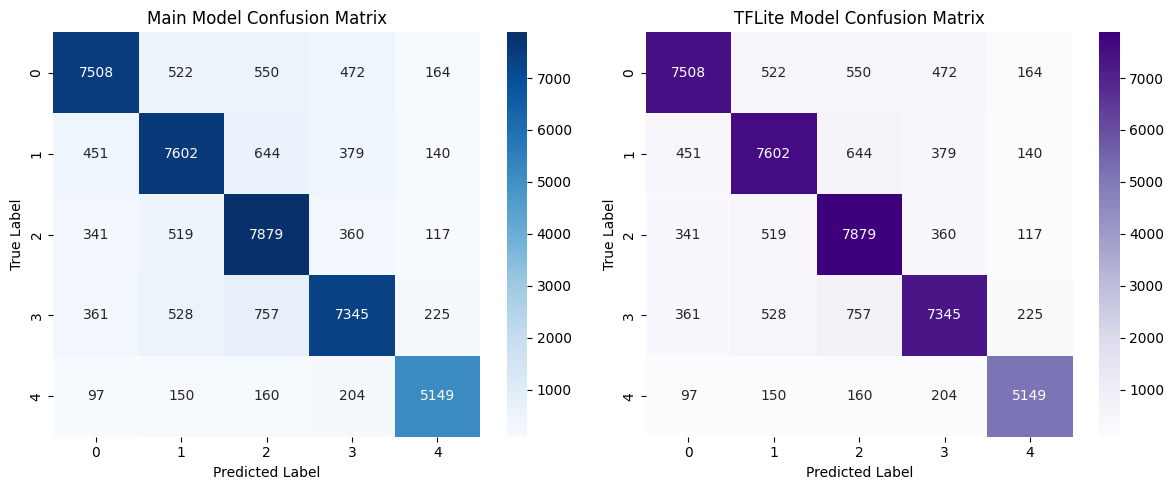

In [21]:


calculate_accuracy_and_confusion_matrix(stop_model_3d, stop_five_flite_model_path, stop_five_X_test, stop_five_y_test)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 6, 10)]           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 6, 128)           38400     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 6, 128)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160

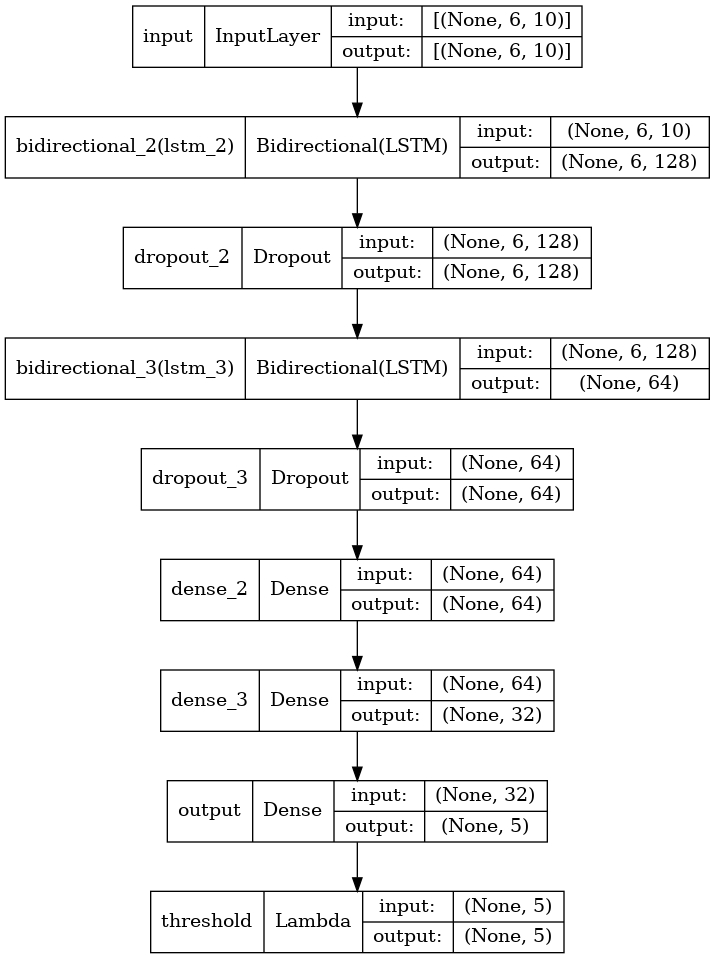

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, Lambda
from tensorflow.keras.utils import plot_model

def build_3d_model(input_shape, num_classes):
    model_input = Input(shape=input_shape, name='input')
    x = Bidirectional(LSTM(64, return_sequences=True))(model_input)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(32))(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)

    # Create a Lambda layer to get the one-hot encoded output
    thresholded_output = Lambda(lambda x: tf.one_hot(tf.argmax(x, axis=-1), depth=num_classes), name='threshold')(output)
    model = Model(inputs=model_input, outputs=[output, thresholded_output])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

# Define input shape and number of classes
input_shape = (6, 10)
num_classes = 5

# Build the model
model = build_3d_model(input_shape, num_classes)

# Plot the model architecture
plot_model(model, to_file='motion_3d_model_plot.png', show_shapes=True, show_layer_names=True)


## checking tflite

In [22]:
def run_tflite_model(tflite_model_path):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Print input and output details for debugging purposes
    print("Input details:", input_details)
    print("Output details:", output_details)

    n_features = input_details[0]['shape'][2]  # Extracting the number of features from the model input shape
    sample_input = np.random.random((1, 6, 10)).astype(np.float32)

    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], sample_input)

    # Run inference
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Print the output data
    print("Output data:", output_data)

In [23]:
run_tflite_model(stop_five_flite_model_path)

Input details: [{'name': 'serving_default_x:0', 'index': 0, 'shape': array([ 1,  6, 10], dtype=int32), 'shape_signature': array([ 1,  6, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:1', 'index': 87, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([1, 5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:0', 'index': 85, 'shape': array([1, 5], dtype=int32), 'shape_signature': array([1, 5], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32